0.027669383824116878


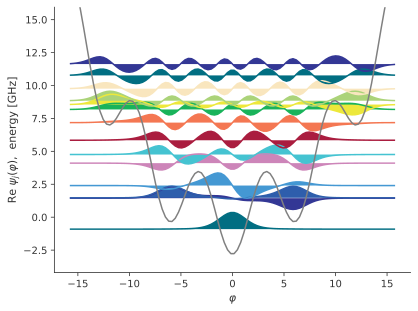

In [1]:
import scqubits
import numpy as np
import matplotlib.pyplot as plt

max_ql = 20
max_ol = 200
EJ = 2.8
EC = 0.75
EL = 0.13
fluxonium = scqubits.Fluxonium(EJ = EJ,EC = EC,EL = EL, cutoff = 110,flux = 0,truncated_dim=max_ql)
from scqubits.core.discretization import Grid1d
fluxonium.plot_wavefunction(which=[0,1,2,3,4,5,6,7,8,9,10,11,12,13],phi_grid=Grid1d(min_val=-5*np.pi,max_val=5*np.pi,pt_count=100))
evals1 = fluxonium.eigenvals(13)
print(evals1[2]-evals1[1])

(<Figure size 640x480 with 2 Axes>, <Axes: >)

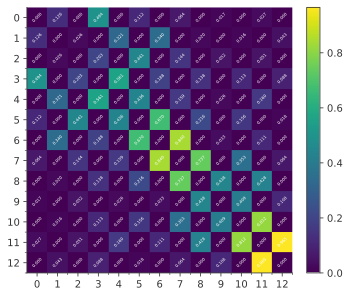

In [8]:
fluxonium.plot_matrixelements('n_operator',evals_count=13, show3d=False,show_numbers=True)

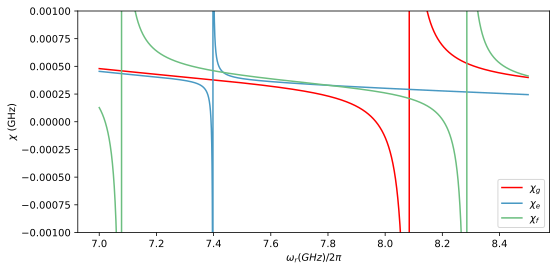

In [2]:
n_evals = 20
qls = [0,1,2]
colors = ['red','#4999c3','#6cbe80']
labels = [r'$\chi_g$',r'$\chi_e$',r'$\chi_f$']


evals1 = fluxonium.eigenvals(n_evals)
matrix1 =  fluxonium.matrixelement_table(operator = "n_operator",evals_count=n_evals)
def get_shift_accurate(ele,omega_i, omega_j, omega_r):
    return abs(ele)**2 / (omega_j-omega_i-omega_r) - abs(ele)**2 / (omega_i-omega_j-omega_r)

fig = plt.figure(figsize=(8, 4)) 
gs = fig.add_gridspec(1,1,left=0.17,right=0.99,bottom=0.18,top=0.95)
ax1 = fig.add_subplot(gs[0])

# zero_three = evals1[3]-evals1[0]
# Er_list1 = np.linspace(zero_three-6,zero_three+6,int(1e4))
Er_list1 = np.linspace(7,8.5,int(1e4))
for ql, label, color in zip(qls, labels, colors):
    shift_from_qubit_transition = []
    for Er in Er_list1:
        shifts = [get_shift_accurate(matrix1[ql,ql2], evals1[ql2], evals1[ql], Er) for ql2 in range(n_evals)] 
        shift_from_qubit_transition.append(sum(shifts)/100)
    ax1.plot(Er_list1,np.array(shift_from_qubit_transition), label= label,color = color)

ax1.set_ylim(-0.001,0.001)
ax1.set_xlabel(rf"$\omega_r (GHz)/2\pi$")
ax1.set_ylabel(rf"$\chi$ (GHz)")
ax1.legend()


In [ ]:
# ! pip install git+https://github.com/JiakaiW/CoupledQuantumSystems      

In [4]:
from CoupledQuantumSystems.systems import FluxoniumOscillatorSystem
import qutip
import pickle
Er =  7.79
g = 0.3
kappa = 5e-3

system  =  FluxoniumOscillatorSystem(
                EJ = EJ,
                EC = EC,
                EL = EL,
                Er = Er,
                g_strength = g,
                kappa = kappa,
                qubit_level = max_ql,
                osc_level = max_ol,
                products_to_keep=[[ql, ol] for ql in range(max_ql) for ol in range(max_ol) ],
                computaional_states = '1,2',
                )

id_wrapped_resonator_destory = qutip.tensor(qutip.identity(max_ql), qutip.destroy(max_ol))
id_wrapped_fluxonium_destory = qutip.tensor(qutip.destroy(max_ql), qutip.identity(max_ol))
resonator_creation_arr = id_wrapped_resonator_destory.dag().full()
resonator_destory_arr= id_wrapped_resonator_destory.full()
fluxonium_creation_arr = id_wrapped_fluxonium_destory.dag().full()
fluxonium_destory_arr= id_wrapped_fluxonium_destory.full()

ladder_overlap = system.get_ladder_overlap_arr(resonator_creation_arr)


def find_next_in_branch(dressed_idx_of_qubit_i_resonator_n:int):
    return np.argmax(ladder_overlap[:,dressed_idx_of_qubit_i_resonator_n])

diagonalization_idx_arr = np.zeros((max_ql,max_ol),dtype=int)
diagonalization_idx_arr_with_marks = np.zeros((max_ql,max_ol),dtype=int)
overlap_idx_arr = np.zeros((max_ql,max_ol),dtype=int)
for ql in range(max_ql):
    for ol in range(max_ol):
        diagonalization_idx_arr[ql,ol] = system.product_to_dressed[(ql,ol)]
        diagonalization_idx_arr_with_marks[ql,ol] = system.product_to_dressed[(ql,ol)]

        if ol < 1:
            overlap_idx_arr[ql,ol] = system.product_to_dressed[(ql,ol)]
        else:
            overlap_idx_arr[ql,ol] = np.argmax(ladder_overlap[:,overlap_idx_arr[ql,ol-1]])

np.allclose(diagonalization_idx_arr, overlap_idx_arr)

for ql in range(max_ql):
    for ol in range(max_ol):
        system.product_to_dressed[(ql,ol)] =  overlap_idx_arr[ql,ol] 

system.set_sign_multiplier()

with open('ef_mcsolve_system_g02_potential_param.pkl', 'wb') as f:
    pickle.dump(system,f)

dressed states:   0%|          | 0/20 [00:00<?, ?it/s]

 /tmp/ipykernel_26985/3724264354.py: 11ComplexWarning: Casting complex values to real discards the imaginary part
dressed states: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


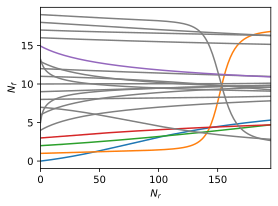

In [5]:
fig,ax = plt.subplots(1,1,figsize=(4,3))
qls = list(range(max_ql))

from tqdm import tqdm
for ql in tqdm(qls,desc='dressed states'):
    dressed_idx_arr = overlap_idx_arr[ql]
    photon_num_arr = np.zeros((max_ol))
    fluxonium_num_arr = np.zeros((max_ol))
    for ol in range(max_ol):
        state_after_a = resonator_destory_arr @ system.evecs[dressed_idx_arr[ol]].full()
        photon_num_arr[ol] = np.sum(state_after_a**2)
        state_after_fluxnonium_a = fluxonium_destory_arr @ system.evecs[dressed_idx_arr[ol]].full()
        fluxonium_num_arr[ol] = np.sum(state_after_fluxnonium_a**2)
    if ql in [0,1,2,3,15]:
        ax.plot(photon_num_arr,fluxonium_num_arr,label=f'{ql}')
    else:
        ax.plot(photon_num_arr,fluxonium_num_arr,label=f'{ql}',color='grey')


ax.set_xlim(0,max_ol-5)
ax.set_xlabel(r'$N_r$')
ax.set_ylabel(r'$N_f$')

plt.tight_layout()

In [6]:
n_osc_lvls = max_ol-1
energies=  system.hilbertspace.eigenvals(max_ql * max_ol)
def dressed_ener(ql,ol):
    return energies[system.product_to_dressed[(ql,ol)]]
dressed_osc_frequencies = [[] for _ in range(3)]
for j in [0,1,2]:
    for i in range(0,max_ol-1):
        dressed_osc_frequencies[j].append(dressed_ener(j,i+1)-dressed_ener(j,i))

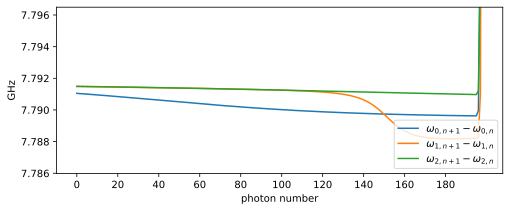

In [7]:
plt.figure(figsize = (8,3))

x_vals = list(range(max_ol-1))[:n_osc_lvls]
y_vals_list = [dressed_osc_frequencies[j][:n_osc_lvls] for j in [0,1,2]]
        
for j in [0,1,2]:
    plt.plot(x_vals,y_vals_list[j],label=rf'$\omega_{{{j},n+1}} - \omega_{{{j},n}}$')

plt.xticks(list(range(n_osc_lvls))[::20])

y_data_arr = np.array([y_vals_list[j][:-10] for i in [0,1,2]])
ymin = np.min(y_data_arr)
ymax = np.max(y_data_arr)
plt.ylim(ymin-0.005, ymax+0.005)
# plt.ylim(7.9,7.92)
plt.ylabel('GHz')
plt.xlabel("photon number")
# plt.xticklabels([str(i) for i in range(n_osc_lvls)])
plt.legend(loc='lower right')